In [11]:
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [10]:
df = pd.read_csv('data/Housing_SalePrice_US.csv')
df.head()

,DATE,MSPUS
0,1963-01-01,17800.0
1,1963-04-01,18000.0
2,1963-07-01,17900.0
3,1963-10-01,18500.0
4,1964-01-01,18500.0


In [5]:
# Datetime objects are easier to work with

print(df.info())

df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')

# After
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    237 non-null    object 
 1   MSPUS   237 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.8+ KB
None


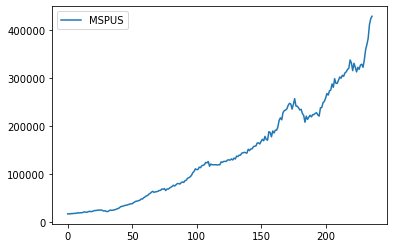

In [12]:
df.plot()
plt.show()